In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [178]:
df = pd.read_csv("data/train.csv")

In [179]:
df.head(3)

,customer_id,product_id,price,week
0,0,5,7.03,1
1,0,39,4.71,1
2,0,53,7.61,1


In [180]:
df.shape

(307838, 4)

In [181]:
len(df) - len(df.drop_duplicates())

0

In [182]:
df.customer_id.unique().max()

1999

In [183]:
df.week.max()

49

In [184]:
# Do prices change? Sure, they do
np.mean([df[df.product_id == i].price.std() != 0 for i in df.product_id.unique()])

0.6

In [185]:
# Nope, they don't... There are minor rounding / floating errors
np.mean([(df[df.product_id == i].price.max() - df[df.product_id == i].price.min()) > 0 for i in df.product_id.unique()])

0.0

# EDA

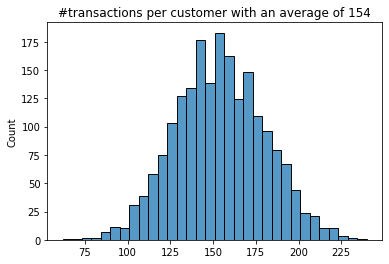

In [186]:
# How many transactions per customer within 49 weeks?
n_transactions_per_customer = [len(df[df.customer_id==i]) for i in df.customer_id.unique()]
sns.histplot(n_transactions_per_customer).set(
    title=f"""#transactions per customer with an average of {
        round(np.mean(n_transactions_per_customer))
        }"""
    );plt.show()

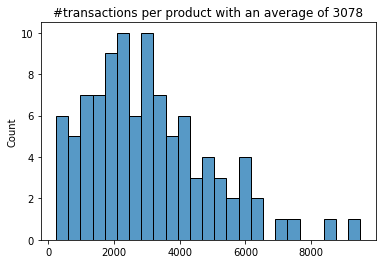

In [187]:
# How many transactions per product within 49 weeks?
n_transactions_per_product = [len(df[df.product_id==i]) for i in df.product_id.unique()]
sns.histplot(n_transactions_per_product, bins=25).set(
    title=f"""#transactions per product with an average of {
        round(np.mean(n_transactions_per_product))
        }"""
    );plt.show()

# Some products were bought far more often than others

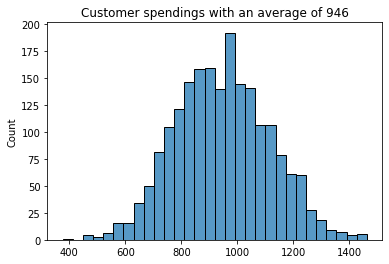

In [188]:
# How much did each customer spend within 49 weeks?
customer_spend = [df[df.customer_id==i].price.sum() for i in df.customer_id.unique()]
sns.histplot(customer_spend).set(
    title=f"""Customer spendings with an average of {
        round(np.mean(customer_spend))
        }"""
    );plt.show()
# Similar picture like n_transactions

In [248]:
customer_sum_spending = df[["customer_id","price"]].groupby(by="customer_id", as_index=False)["price"].sum()
customer_sum_spending["pays_above_avg"] = (customer_sum_spending.price > customer_sum_spending.price.mean()).astype(int)
customer_sum_spending.head()

,customer_id,price,pays_above_avg
0,0,783.29,0
1,1,1012.11,1
2,2,701.89,0
3,3,569.13,0
4,4,1041.76,1


In [273]:
cp_affection= df[["customer_id","product_id"]].groupby(by=["customer_id","product_id"], as_index=False).value_counts().sort_values(by=["customer_id","count"])
#cp_affection[cp_affection.customer_id==0].sort_values(by="count", ascending=False)
print(cp_affection.shape)
print(len(cp_affection.customer_id.unique()), len(cp_affection.product_id.unique()))
cp_affection.head()

(47842, 3)
2000 100


,customer_id,product_id,count
1,0,10,1
3,0,28,1
5,0,33,1
6,0,34,1
10,0,61,1


In [269]:
product_prices = df[["product_id","price"]].groupby(by="product_id", as_index=False)["price"].mean()
product_prices["costs_above_avg"] = (product_prices.price > product_prices.price.mean()).astype(int)
product_prices.head(10)

,product_id,price,costs_above_avg
0,0,5.76,0
1,1,6.33,1
2,2,7.81,1
3,3,7.11,1
4,4,5.83,0
5,5,7.03,1
6,6,6.82,1
7,7,6.91,1
8,8,6.17,0
9,9,5.47,0


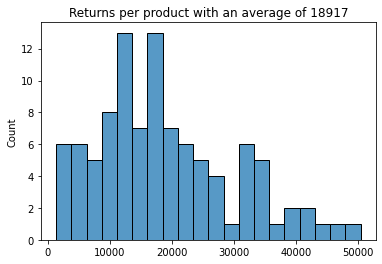

In [189]:
# How much return per product within 49 weeks?
returns_per_product = [df[df.product_id==i].price.sum() for i in df.product_id.unique()]
sns.histplot(returns_per_product, bins=20).set(
    title=f"""Returns per product with an average of {
        round(np.mean(returns_per_product))
        }"""
    );plt.show()

# Similar picture like transactions per product

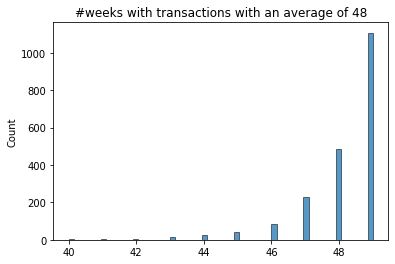

In [190]:
# In how many weeks was a customer active?
len(df[df.customer_id==1].groupby(by="week"))

n_weeks_with_transactions = [len(df[df.customer_id==i].groupby(by="week")) for i in df.customer_id.unique()]
sns.histplot(n_weeks_with_transactions).set(
    title=f"""#weeks with transactions with an average of {
        round(np.mean(n_weeks_with_transactions))
        }"""
    );plt.show()

# Some customers bought products every week (could be me), others only bought sth in 40 of 49 weeks.

# Possible Features

In [191]:
# TODO: Make prefix/suffix usage same for ALL features/columns e.g. {feature name}{time}{aggregation}... currently it's mixed up

# Customer Features (joins by id & id+week)
customer_static_features = {
    "customer_id" : [],                             #(/)
    "avg_n_transactions_weekly_customer": [],       #(/)
    "avg_spending_weekly": [],                      #(/)
    # "customer_segment": [],
}

customer_dynamic_features = {
    "customer_id": [],
    "week": [],
    "n_transactions_last_week_customer" : [],
    "sum_spending_last_week": []
}

# Product Features (joins by id & id+week)
product_static_features = {
    "product_id" : [],
    "avg_n_transactions_weekly_product": [],
    "avg_returns_weekly": [],
    # "product_segment" : [],
    "avg_price_weekly":[]
}

product_dynamic_features = {
    "product_id" : [],
    "week" : [],
    "n_transactions_last_week_product" : [],
    "sum_returns_last_week": [],
    "current_price": [], # data will be incomplete, QUICKFIX: use last price or mean
    "price_delta_to_last_week": [] 
}

# Customer & Product Cluster

In [192]:
len(df[df.customer_id==1].groupby(by="week"))

48

In [193]:
# How many transactions does the customer 0 have during active weeks (weeks he made transactions)
df[df.customer_id==0].groupby(by="week").size().mean()

2.489795918367347

# Data Skeleton
To take transactions that did not happen into account and to create a label, we create a skeleton.

In [194]:
# skeleton dataframe
skeleton_dict = {
    "customer_id": [],
    "product_id": [],
    "week":[]
}

skeleton = pd.DataFrame(skeleton_dict)

In [195]:
# customer product pairs
n_customers, n_products = 2000, 100
cp_gen = ((c, p)  for c in range(n_customers) for p in range(n_products))
skeleton_cp = pd.DataFrame(cp_gen, columns=["customer_id", "product_id"])

In [196]:
# Filling skeleton
n_weeks = 50

for w in range(1,n_weeks+1):
    tmp = skeleton_cp.copy()
    tmp["week"] = [w] * len(skeleton_cp)
    skeleton = pd.concat([skeleton, tmp], ignore_index=True)

In [197]:
len(skeleton) == n_customers * n_products * n_weeks

True

In [198]:
df[["customer_id","product_id","week"]].dtypes.to_dict()

{'customer_id': dtype('int64'),
 'product_id': dtype('int64'),
 'week': dtype('int64')}

In [199]:
# Type alignment
skeleton = skeleton.astype(df[["customer_id","product_id","week"]].dtypes.to_dict())
skeleton.head()

,customer_id,product_id,week
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1


In [200]:
# Add label
df["label"] = [1] * len(df)
df.head(3)

,customer_id,product_id,price,week,label
0,0,5,7.03,1,1
1,0,39,4.71,1,1
2,0,53,7.61,1,1


In [201]:
# Merge Skeleton & completed transactions (df)
merged = skeleton.merge(
    right=df, 
    how="left", 
    on=["customer_id", "product_id", "week"],
    validate="1:m"
    )
print(len(merged))

merged.head(10)

10000000


,customer_id,product_id,week,price,label
0,0,0,1,NaN,NaN
1,0,1,1,NaN,NaN
2,0,2,1,NaN,NaN
3,0,3,1,NaN,NaN
4,0,4,1,NaN,NaN
5,0,5,1,7.03,1.0
6,0,6,1,NaN,NaN
7,0,7,1,NaN,NaN
8,0,8,1,NaN,NaN
9,0,9,1,NaN,NaN


# Building customer features

In [202]:
# sum of transactions and spendings per customer per week
weekly_transactions_customer = merged.groupby(by=["customer_id","week"], as_index=False)[["price","label"]].sum()
weekly_transactions_customer.rename(columns={"label":"n_transactions_customer", "price":"weekly_spending"}, inplace=True)
weekly_transactions_customer.head(3)

,customer_id,week,weekly_spending,n_transactions_customer
0,0,1,25.39,4.0
1,0,2,26.34,4.0
2,0,3,14.01,2.0


In [203]:
merged.groupby(by="customer_id", as_index=False)["price"].max()

,customer_id,price
0,0,7.86
1,1,8.86
2,2,8.47
3,3,7.75
4,4,8.77
...,...,...
1995,1995,7.60
1996,1996,7.95
1997,1997,8.86
1998,1998,8.47


In [204]:
weekly_transactions_customer.shape

(100000, 4)

In [205]:
n_customers*n_weeks

100000

For week 50 (1-step-ahead-prediction) we don't know spendings and transactions. Thus, we can't use them for the current week directly. However we can use data from previous weeks as dynamic data.

In [206]:
weekly_transactions_customer["sum_spending_last_week"] = weekly_transactions_customer["weekly_spending"].shift(periods=1)
weekly_transactions_customer["n_transactions_last_week_customer"] = weekly_transactions_customer["n_transactions_customer"].shift(periods=1)
weekly_transactions_customer.head(3)

,customer_id,week,weekly_spending,n_transactions_customer,sum_spending_last_week,n_transactions_last_week_customer
0,0,1,25.39,4.0,NaN,NaN
1,0,2,26.34,4.0,25.39,4.0
2,0,3,14.01,2.0,26.34,4.0


In [207]:
customer_static_features = {
    "customer_id" : [],                             #(/)
    "avg_n_transactions_weekly_customer": [],       #(/)
    "avg_spending_weekly": [],                      #(/)
    # "customer_segment": [],
    # highest price paid
}

for customer in df.customer_id.unique():

    customer_static_features["customer_id"].append(customer)

    customer_static_features["avg_n_transactions_weekly_customer"].append(
        weekly_transactions_customer[
            (weekly_transactions_customer.customer_id == customer)&(weekly_transactions_customer.week < 50)].n_transactions_customer.mean()
    )

    customer_static_features["avg_spending_weekly"].append(
        weekly_transactions_customer[
            (weekly_transactions_customer.customer_id == customer)&(weekly_transactions_customer.week < 50)].weekly_spending.mean()
    )

customer_static = pd.DataFrame(customer_static_features)

print(customer_static.shape)
customer_static.head(3)

(2000, 3)


,customer_id,avg_n_transactions_weekly_customer,avg_spending_weekly
0,0,2.489796,15.985510
1,1,3.346939,20.655306
2,2,2.285714,14.324286


In [208]:
customer_dynamic = weekly_transactions_customer[["customer_id","week", "sum_spending_last_week", "n_transactions_last_week_customer"]]

print(customer_dynamic.shape)
customer_dynamic.tail(3)

(100000, 4)


,customer_id,week,sum_spending_last_week,n_transactions_last_week_customer
99997,1999,48,23.68,4.0
99998,1999,49,16.85,3.0
99999,1999,50,30.54,5.0


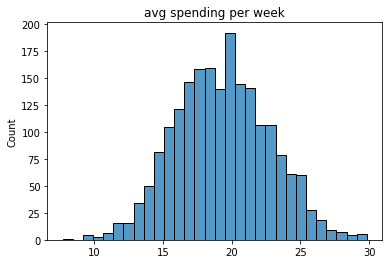

In [209]:
# customer segments (low-, mid- highspender)
sns.histplot(customer_static_features["avg_spending_weekly"]).set(title="avg spending per week");plt.show()

In [210]:
# NOTE: The customer segment will highly correlate with spending.
# sigma = np.std(customer_static_features["avg_spending_weekly"])
# mean = np.mean(customer_static_features["avg_spending_weekly"])

# def segment(spending):


# Building product features

In [211]:
# sum of transactions and returns per product per week
weekly_transactions_product = merged.groupby(by=["product_id","week"], as_index=False)[["price","label"]].sum()
weekly_transactions_product.rename(columns={"label":"n_transactions_product", "price":"weekly_returns"}, inplace=True)
weekly_transactions_product["current_price"] = weekly_transactions_product.weekly_returns/weekly_transactions_product.n_transactions_product
weekly_transactions_product.head(3)

,product_id,week,weekly_returns,n_transactions_product,current_price
0,0,1,207.36,36.0,5.76
1,0,2,224.64,39.0,5.76
2,0,3,207.36,36.0,5.76


In [212]:
weekly_transactions_product.shape

(5000, 5)

In [213]:
product_static_features = {
    "product_id" : [],
    "avg_n_transactions_weekly_product": [],
    "avg_returns_weekly": [],
    "avg_price_weekly":[]
}

for product in df.product_id.unique():

    product_static_features["product_id"].append(product)

    product_static_features["avg_n_transactions_weekly_product"].append(
        weekly_transactions_product[
            (weekly_transactions_product.product_id == product)& (weekly_transactions_product.week < 50)].n_transactions_product.mean()
    )

    product_static_features["avg_returns_weekly"].append(
        weekly_transactions_product[
            (weekly_transactions_product.product_id == product) & (weekly_transactions_product.week < 50)].weekly_returns.mean()
    )
    product_static_features["avg_price_weekly"].append(
        weekly_transactions_product[
            (weekly_transactions_product.product_id == product) & (weekly_transactions_product.week < 50)].current_price.mean()

    )

product_static = pd.DataFrame(product_static_features)
product_static.sort_values(by="product_id",inplace=True)

print(product_static.shape)
product_static.head(3)

(100, 4)


,product_id,avg_n_transactions_weekly_product,avg_returns_weekly,avg_price_weekly
77,0,40.285714,232.045714,5.76
74,1,44.795918,283.558163,6.33
16,2,32.306122,252.310816,7.81


In [214]:
# Product Lag Features
    # "n_transactions_last_week_product" : [],
    # "sum_returns_last_week": [],
    # "current_price": [], # data will be incomplete, QUICKFIX: use last price or mean
    # "price_delta_to_last_week": [] 
# 
weekly_transactions_product["sum_returns_last_week"] = weekly_transactions_product["weekly_returns"].shift(periods=1)
weekly_transactions_product["n_transactions_last_week_product"] = weekly_transactions_product["n_transactions_product"].shift(periods=1)
weekly_transactions_product["last_week_price"] = weekly_transactions_product["current_price"].shift(periods=1)
# product 75 price is missing in week 24, fixing it with bfill
weekly_transactions_product["last_week_price"].bfill(inplace=True)
weekly_transactions_product.head(3)

,product_id,week,weekly_returns,n_transactions_product,current_price,sum_returns_last_week,n_transactions_last_week_product,last_week_price
0,0,1,207.36,36.0,5.76,NaN,NaN,5.76
1,0,2,224.64,39.0,5.76,207.36,36.0,5.76
2,0,3,207.36,36.0,5.76,224.64,39.0,5.76


In [215]:
product_dynamic = weekly_transactions_product[["product_id","week", "sum_returns_last_week", "n_transactions_last_week_product", "last_week_price"]]

print(product_dynamic.shape)
product_dynamic.tail(3)

(5000, 5)


,product_id,week,sum_returns_last_week,n_transactions_last_week_product,last_week_price
4997,99,48,406.64,52.0,7.82
4998,99,49,406.64,52.0,7.82
4999,99,50,375.36,48.0,7.82


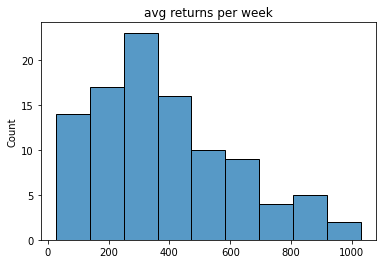

In [216]:
sns.histplot(product_static_features["avg_returns_weekly"]).set(title="avg returns per week");plt.show()

# Add Customer & Product Features to Skeleton


In [217]:
merged_combo = merged.merge(
    right=customer_static, 
    how="left", 
    on="customer_id",
    validate="m:1"
    )

merged_combo.head()

,customer_id,product_id,week,price,label,avg_n_transactions_weekly_customer,avg_spending_weekly
0,0,0,1,NaN,NaN,2.489796,15.98551
1,0,1,1,NaN,NaN,2.489796,15.98551
2,0,2,1,NaN,NaN,2.489796,15.98551
3,0,3,1,NaN,NaN,2.489796,15.98551
4,0,4,1,NaN,NaN,2.489796,15.98551


In [218]:
merged_combo = merged_combo.merge(
    right=customer_dynamic, 
    how="left", 
    on=["customer_id", "week"],
    validate="m:1"
    )
print(merged_combo.shape)

merged_combo.head()

(10000000, 9)


,customer_id,product_id,week,price,label,avg_n_transactions_weekly_customer,avg_spending_weekly,sum_spending_last_week,n_transactions_last_week_customer
0,0,0,1,NaN,NaN,2.489796,15.98551,NaN,NaN
1,0,1,1,NaN,NaN,2.489796,15.98551,NaN,NaN
2,0,2,1,NaN,NaN,2.489796,15.98551,NaN,NaN
3,0,3,1,NaN,NaN,2.489796,15.98551,NaN,NaN
4,0,4,1,NaN,NaN,2.489796,15.98551,NaN,NaN


In [219]:
merged_combo = merged_combo.merge(
    right=product_static, 
    how="left", 
    on=["product_id"],
    validate="m:1"
    )
print(merged_combo.shape)

merged_combo.head()

(10000000, 12)


,customer_id,product_id,week,price,label,avg_n_transactions_weekly_customer,avg_spending_weekly,sum_spending_last_week,n_transactions_last_week_customer,avg_n_transactions_weekly_product,avg_returns_weekly,avg_price_weekly
0,0,0,1,NaN,NaN,2.489796,15.98551,NaN,NaN,40.285714,232.045714,5.76
1,0,1,1,NaN,NaN,2.489796,15.98551,NaN,NaN,44.795918,283.558163,6.33
2,0,2,1,NaN,NaN,2.489796,15.98551,NaN,NaN,32.306122,252.310816,7.81
3,0,3,1,NaN,NaN,2.489796,15.98551,NaN,NaN,33.102041,235.355510,7.11
4,0,4,1,NaN,NaN,2.489796,15.98551,NaN,NaN,54.367347,316.961633,5.83


In [220]:
merged_combo = merged_combo.merge(
    right=product_dynamic, 
    how="left", 
    on=["product_id", "week"],
    validate="m:1"
    )
print(merged_combo.shape)

merged_combo.head()

(10000000, 15)


,customer_id,product_id,week,price,label,avg_n_transactions_weekly_customer,avg_spending_weekly,sum_spending_last_week,n_transactions_last_week_customer,avg_n_transactions_weekly_product,avg_returns_weekly,avg_price_weekly,sum_returns_last_week,n_transactions_last_week_product,last_week_price
0,0,0,1,NaN,NaN,2.489796,15.98551,NaN,NaN,40.285714,232.045714,5.76,NaN,NaN,5.76
1,0,1,1,NaN,NaN,2.489796,15.98551,NaN,NaN,44.795918,283.558163,6.33,0.0,0.0,6.33
2,0,2,1,NaN,NaN,2.489796,15.98551,NaN,NaN,32.306122,252.310816,7.81,0.0,0.0,7.81
3,0,3,1,NaN,NaN,2.489796,15.98551,NaN,NaN,33.102041,235.355510,7.11,0.0,0.0,7.11
4,0,4,1,NaN,NaN,2.489796,15.98551,NaN,NaN,54.367347,316.961633,5.83,0.0,0.0,5.83


In [221]:
merged_combo = merged_combo[merged_combo.week > 1]  # lag/lead features
merged_combo.label.fillna(0, inplace=True)          # NaN ~ no transaction
merged_combo.tail()

,customer_id,product_id,week,price,label,avg_n_transactions_weekly_customer,avg_spending_weekly,sum_spending_last_week,n_transactions_last_week_customer,avg_n_transactions_weekly_product,avg_returns_weekly,avg_price_weekly,sum_returns_last_week,n_transactions_last_week_product,last_week_price
9999995,1999,95,50,NaN,0.0,3.489796,21.14551,30.54,5.0,48.122449,323.382857,6.72,342.72,51.0,6.72
9999996,1999,96,50,NaN,0.0,3.489796,21.14551,30.54,5.0,53.857143,387.771429,7.20,446.40,62.0,7.20
9999997,1999,97,50,NaN,0.0,3.489796,21.14551,30.54,5.0,84.163265,517.604082,6.15,522.75,85.0,6.15
9999998,1999,98,50,NaN,0.0,3.489796,21.14551,30.54,5.0,61.959184,355.645714,5.74,350.14,61.0,5.74
9999999,1999,99,50,NaN,0.0,3.489796,21.14551,30.54,5.0,46.551020,364.028980,7.82,375.36,48.0,7.82


In [222]:
# explicit is better than implicit
merged_combo = merged_combo.astype({
    "label":"int64", 
    "n_transactions_last_week_customer":"int64", 
    "n_transactions_last_week_product": "int64"
    })
merged_combo.tail()

,customer_id,product_id,week,price,label,avg_n_transactions_weekly_customer,avg_spending_weekly,sum_spending_last_week,n_transactions_last_week_customer,avg_n_transactions_weekly_product,avg_returns_weekly,avg_price_weekly,sum_returns_last_week,n_transactions_last_week_product,last_week_price
9999995,1999,95,50,NaN,0,3.489796,21.14551,30.54,5,48.122449,323.382857,6.72,342.72,51,6.72
9999996,1999,96,50,NaN,0,3.489796,21.14551,30.54,5,53.857143,387.771429,7.20,446.40,62,7.20
9999997,1999,97,50,NaN,0,3.489796,21.14551,30.54,5,84.163265,517.604082,6.15,522.75,85,6.15
9999998,1999,98,50,NaN,0,3.489796,21.14551,30.54,5,61.959184,355.645714,5.74,350.14,61,5.74
9999999,1999,99,50,NaN,0,3.489796,21.14551,30.54,5,46.551020,364.028980,7.82,375.36,48,7.82


In [223]:
ids = ["customer_id", "product_id"]
training = merged_combo.columns[4:]
features = merged_combo.columns[5:]

In [224]:
mask = merged_combo.week == 50

ids_w_50 = merged_combo[mask][ids]
features_w_50 = merged_combo[mask][features]

In [225]:
ids_w_50.head(3)

,customer_id,product_id
9800000,0,0
9800001,0,1
9800002,0,2


In [226]:
features_w_50.head(3)

,avg_n_transactions_weekly_customer,avg_spending_weekly,sum_spending_last_week,n_transactions_last_week_customer,avg_n_transactions_weekly_product,avg_returns_weekly,avg_price_weekly,sum_returns_last_week,n_transactions_last_week_product,last_week_price
9800000,2.489796,15.98551,14.48,2,40.285714,232.045714,5.76,236.16,41,5.76
9800001,2.489796,15.98551,14.48,2,44.795918,283.558163,6.33,316.50,50,6.33
9800002,2.489796,15.98551,14.48,2,32.306122,252.310816,7.81,265.54,34,7.81


In [227]:
df_training = merged_combo[~mask][training]

print(df_training.shape)
df_training.head(3)

(9600000, 11)


,label,avg_n_transactions_weekly_customer,avg_spending_weekly,sum_spending_last_week,n_transactions_last_week_customer,avg_n_transactions_weekly_product,avg_returns_weekly,avg_price_weekly,sum_returns_last_week,n_transactions_last_week_product,last_week_price
200000,0,2.489796,15.98551,25.39,4,40.285714,232.045714,5.76,207.36,36,5.76
200001,0,2.489796,15.98551,25.39,4,44.795918,283.558163,6.33,303.84,48,6.33
200002,0,2.489796,15.98551,25.39,4,32.306122,252.310816,7.81,234.30,30,7.81


In [228]:
df_training.label.mean()

0.031408125

In [229]:
#df_training.to_parquet("training.parquet")

Features are correlating more with each other than with the label. We need more & better features. Maybe we could predict the price for week 50? The difference to week 49 might have some influence... Good idea. However, it turns out that prices in this example are constant. Thus we can remove 'last_week_price' and 'avg_price_weekly' and simply use the price.

In [230]:
corr_matrix = df_training.corr().abs().round(3)
display(corr_matrix.style.background_gradient(cmap='coolwarm'))

,label,avg_n_transactions_weekly_customer,avg_spending_weekly,sum_spending_last_week,n_transactions_last_week_customer,avg_n_transactions_weekly_product,avg_returns_weekly,avg_price_weekly,sum_returns_last_week,n_transactions_last_week_product,last_week_price
label,1.000000,0.031000,0.030000,0.007000,0.007000,0.109000,0.103000,0.020000,0.101000,0.107000,0.020000
avg_n_transactions_weekly_customer,0.031000,1.000000,0.970000,0.379000,0.386000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
avg_spending_weekly,0.030000,0.970000,1.000000,0.391000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sum_spending_last_week,0.007000,0.379000,0.391000,1.000000,0.982000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
n_transactions_last_week_customer,0.007000,0.386000,0.375000,0.982000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
avg_n_transactions_weekly_product,0.109000,0.000000,0.000000,0.000000,0.000000,1.000000,0.945000,0.186000,0.931000,0.986000,0.186000
avg_returns_weekly,0.103000,0.000000,0.000000,0.000000,0.000000,0.945000,1.000000,0.094000,0.984000,0.932000,0.094000
avg_price_weekly,0.020000,0.000000,0.000000,0.000000,0.000000,0.186000,0.094000,1.000000,0.092000,0.184000,1.000000
sum_returns_last_week,0.101000,0.000000,0.000000,0.000000,0.000000,0.931000,0.984000,0.092000,1.000000,0.947000,0.092000
n_transactions_last_week_product,0.107000,0.000000,0.000000,0.000000,0.000000,0.986000,0.932000,0.184000,0.947000,1.000000,0.184000


In [231]:
s = corr_matrix.unstack()
for row in s.sort_values(kind="quicksort", ascending=False).iteritems():
    if (row[0][0]!=row[0][1]) & (row[1] > 0.95):
        print(row)

(('last_week_price', 'avg_price_weekly'), 1.0)
(('avg_price_weekly', 'last_week_price'), 1.0)
(('avg_n_transactions_weekly_product', 'n_transactions_last_week_product'), 0.986)
(('n_transactions_last_week_product', 'avg_n_transactions_weekly_product'), 0.986)
(('avg_returns_weekly', 'sum_returns_last_week'), 0.984)
(('sum_returns_last_week', 'avg_returns_weekly'), 0.984)
(('n_transactions_last_week_customer', 'sum_spending_last_week'), 0.982)
(('sum_spending_last_week', 'n_transactions_last_week_customer'), 0.982)
(('avg_n_transactions_weekly_customer', 'avg_spending_weekly'), 0.97)
(('avg_spending_weekly', 'avg_n_transactions_weekly_customer'), 0.97)


In [232]:
# FIXME: all plots are showing a continuous line. Something went wrong. The only price changes are rounding errors.
# NOTE: No error... Seems like prices are constant.
# np.mean([df[df.product_id == i].price.std() != 0 for i in df.product_id.unique()])
# #sns.histplot([weekly_transactions_product[weekly_transactions_product.product_id == i].current_price.std() for i in weekly_transactions_product.product_id.unique()])
# for product in weekly_transactions_product.product_id.unique():
#     show_me = weekly_transactions_product[weekly_transactions_product.product_id == product]
#     if show_me.current_price.std() != 0:
#     # sns.histplot(show_me.current_price);plt.show()
#         sns.lineplot(x=show_me.week, y=show_me.current_price).set(
#             title=f"product_id: {product} min: {show_me.current_price.min()} max: {show_me.current_price.max()}"
#             );plt.show()
#weekly_transactions_product[["product_id","week", "current_price"]]

In [233]:
for product in df.product_id.unique():
    show_me = df[df.product_id == product][["week", "price"]]
    print(show_me.price.std())
    break
    if (show_me.price.max() - show_me.price.min()) > 0:
        print(f"product_id: {product} min: {show_me.price.min()} max: {show_me.price.max()}")

    # sns.lineplot(x=show_me.week, y=show_me.price).set(
        # title=
        # );plt.show()

0.0


In [234]:
# TODO: Try n_transactions forecast (general trend)
# TODO: Try Regressor on current week n_transactions


In [235]:
weekly_returns = df[["week", "price"]].groupby(by="week", as_index=False)["price"].sum().rename(columns={"price":"sum_returns"})
weekly_returns["moving_avg_returns_lm"]=weekly_returns.sum_returns.rolling(4).mean()

# Make it last weeks data
weekly_returns.week = weekly_returns.week + 1
weekly_returns.tail(3)

,week,sum_returns,moving_avg_returns_lm
46,48,38719.42,38790.1400
47,49,39116.56,38964.2075
48,50,38371.94,38849.4225


<AxesSubplot:xlabel='week', ylabel='sum_returns'>

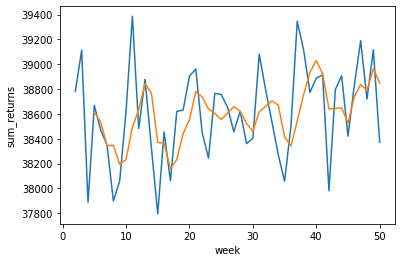

In [236]:
sns.lineplot(x=weekly_returns.week, y=weekly_returns.sum_returns)
sns.lineplot(x=weekly_returns.week, y=weekly_returns.moving_avg_returns_lm)

In [237]:

weekly_transactions = pd.DataFrame({
    "week": list(df["week"].value_counts().index),
    "sum_transactions": df["week"].value_counts().values
})
weekly_transactions.sort_values(by="week",inplace=True)
weekly_transactions["moving_avg_transactions_lm"]=weekly_transactions.sum_transactions.rolling(4).mean()
# Make it last weeks data
weekly_transactions.week = weekly_transactions.week + 1
weekly_transactions.head()

,week,sum_transactions,moving_avg_transactions_lm
11,2,6320,NaN
5,3,6359,NaN
46,4,6175,NaN
26,5,6278,6283.00
37,6,6245,6264.25


In [238]:
weekly_transactions.shape

(49, 3)

<AxesSubplot:xlabel='week', ylabel='sum_transactions'>

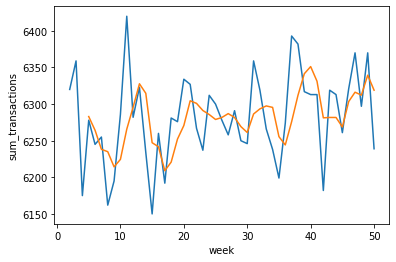

In [239]:
sns.lineplot(x=weekly_transactions.week, y=weekly_transactions.sum_transactions)
sns.lineplot(x=weekly_transactions.week, y=weekly_transactions.moving_avg_transactions_lm)

In [240]:
weekly_aggregation = weekly_returns.merge(weekly_transactions, how="left", on="week", validate="1:1")
weekly_aggregation.head()

,week,sum_returns,moving_avg_returns_lm,sum_transactions,moving_avg_transactions_lm
0,2,38781.01,NaN,6320,NaN
1,3,39113.79,NaN,6359,NaN
2,4,37887.53,NaN,6175,NaN
3,5,38667.74,38612.5175,6278,6283.00
4,6,38469.89,38534.7375,6245,6264.25


In [242]:
merged[merged.product_id == 0].price.max()

5.76

In [ ]:
# customer pays more than average